# Brain Tumor Detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
from sklearn.utils import shuffle
from PIL import Image
%matplotlib inline

In [2]:
# Need to check if cuda is avaiable, to shift tensors and network to GPUs
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

## Custom Data Generator

In [3]:
from glob import glob
class BrainMRIDataset(Dataset):
    
    def __init__(self,data_dir,reshape=True,height=128,width=128,autoencoder=False):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.autoencoder = autoencoder
        
        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]
        
        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })
        
        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)
        
    def __len__(self):
        return len(self.no_class)+len(self.yes_class)
    
    def __getitem__(self,idx):
        
        image_list = self.dataframe['image'][idx]
        label_list = self.dataframe['labels'][idx]
        
        if type(image_list) == str:
            image_list = [image_list]

        if not isinstance(label_list,np.int64):
            label_list = label_list.values

        image_array = []
        for image in image_list:
            image = Image.open(image).convert("L")
            if self.reshape:
                image = image.resize((self.height,self.width))

            array = np.asarray(image)
        
            if self.autoencoder:
                array = array.reshape(self.height*self.width)
            else:
                array = array.reshape(1,self.height,self.width)
            
            image_array.append(array)
        
        return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]
    
    def __repr__(self):
        return str(self.dataframe.head())

In [4]:
!unzip brain-mri-images-for-brain-tumor-detection.zip  && rm brain-mri-images-for-brain-tumor-detection.zip

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_datase

In [5]:
dataset = BrainMRIDataset("brain_tumor_dataset")
print(dataset)

                              image  labels
0  brain_tumor_dataset/no/26 no.jpg       0
1   brain_tumor_dataset/yes/Y55.jpg       1
2   brain_tumor_dataset/yes/Y23.JPG       1
3  brain_tumor_dataset/no/25 no.jpg       0
4  brain_tumor_dataset/yes/Y247.JPG       1


# Autoencoder
In this section, we will be looking into an Autoencoder Implementation, which will try to understand the underlying distribution of Data, and try to create brain images using Models.

In [12]:
dataset_autoencoder = BrainMRIDataset("brain_tumor_dataset",autoencoder=True,height=28,width=28)

In [13]:
class BrainTumorAutoencodes(nn.Module):
    
    def __init__(self,dim):
        
        super().__init__()
        self.lin1 = nn.Linear(dim*dim,542)
        self.lin2 = nn.Linear(542,345)
        self.lin3 = nn.Linear(345,128)
        self.lin4 = nn.Linear(128,64)
        self.lin5 = nn.Linear(64,32)
        self.lin6 = nn.Linear(32,64)
        self.lin7 = nn.Linear(64,128)
        self.lin8 = nn.Linear(128,345)
        self.lin9 = nn.Linear(345,542)
        self.lin10 = nn.Linear(542,dim*dim)

    def forward(self,x):
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        x = F.relu(self.lin3(x))
        x = F.relu(self.lin4(x))
        x = self.lin5(x)
        x = F.relu(self.lin6(x))
        x = F.relu(self.lin7(x))
        x = self.lin8(x)
        x = F.relu(self.lin9(x))
        x = F.relu(self.lin10(x))

        return x
        

In [14]:
autoencoder = BrainTumorAutoencodes(28)
autoencoder.to(device)

BrainTumorAutoencodes(
  (lin1): Linear(in_features=784, out_features=542, bias=True)
  (lin2): Linear(in_features=542, out_features=345, bias=True)
  (lin3): Linear(in_features=345, out_features=128, bias=True)
  (lin4): Linear(in_features=128, out_features=64, bias=True)
  (lin5): Linear(in_features=64, out_features=32, bias=True)
  (lin6): Linear(in_features=32, out_features=64, bias=True)
  (lin7): Linear(in_features=64, out_features=128, bias=True)
  (lin8): Linear(in_features=128, out_features=345, bias=True)
  (lin9): Linear(in_features=345, out_features=542, bias=True)
  (lin10): Linear(in_features=542, out_features=784, bias=True)
)

In [15]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters())

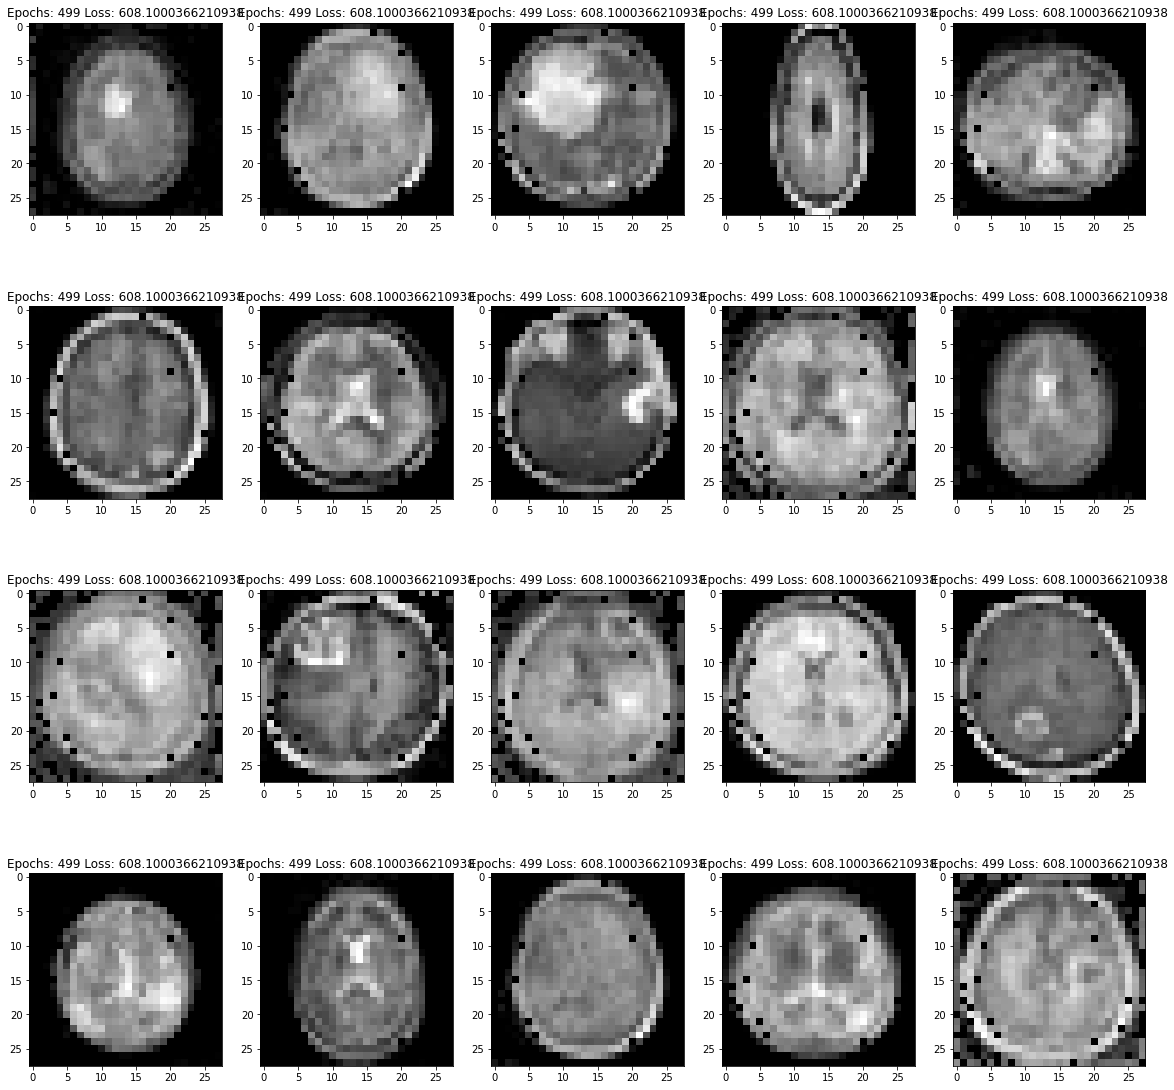

In [16]:
from IPython.display import clear_output
epochs = 500
batch_size = 32
loss_list = []
for epoch in range(epochs):
    clear_output(True)
    total_loss = 0
    for n in range(len(dataset_autoencoder)//batch_size):
    
        data,target = dataset_autoencoder[n*batch_size:(n+1)*batch_size]

        ypred = autoencoder.forward(data.float())
        loss = loss_fn(ypred,data.float())

        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
    loss_list.append(total_loss/batch_size)
    
    figure = plt.figure(figsize=(20,20))
    for i in range(20):
        plt.subplot(4,5,i+1)
        image = ypred[i].cpu().detach().numpy()# plot the sample
        image = image.reshape(28,28)
        fig = plt.figure
        plt.imshow(image, cmap='gray')
        plt.title(f'Epochs: {epoch} Loss: {total_loss/n}')
    plt.show()

## Custom Neural Network Class

This class will inherit the properties from ```torch.nn.Module``` and should have two functions ```__init__``` for defining neural network and ```forward``` for forward propogation. In General, forward function, will be dealing with output from each layer. We can apply MaxPool, Dropouts and other activation functions.

In [6]:
class BrainTumorModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,256,kernel_size=3),
            nn.MaxPool2d(2,2),
            nn.Conv2d(256,32,kernel_size=2)
        )
        self.linear1 = nn.Linear(62,128)
        self.linear2 = nn.Linear(128,64)
        self.flat = nn.Flatten(1)
        self.linear3 = nn.Linear(126976,2)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)

        return x

In [7]:
model = BrainTumorModel()
model.to(device)

BrainTumorModel(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(256, 32, kernel_size=(2, 2), stride=(1, 1))
  )
  (linear1): Linear(in_features=62, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear3): Linear(in_features=126976, out_features=2, bias=True)
)

# Convolutional Neural Network - Classification

## Model Training

1. Loss Function: ```torch.nn``` Module having predefined loss functions and you can create your own Loss functions as defined above. Using CrossEntropyLoss for 2 Outputs, for examining the individual probabilities

2. Optimizer: ```torch.nn``` having pre-defined optimizers, with many parameters, using Adam here

3. After defining epochs, need to loop over some steps
    * Fitting Data with batch of dataset
    * Compute the Loss
    * Make Gradient Zero, for previous computations
    * Compute the backward propogation (Derivate calculation)
    * Optimizing the weight and biases

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [9]:
epochs = 200
batch_size = 32
loss_list = []
for epoch in range(epochs):
    total_loss = 0
    for n in range(len(dataset)//batch_size):
    
        data,target = dataset[n*batch_size:(n+1)*batch_size]

        ypred = model.forward(data.float())
        loss = loss_fn(ypred,target)

        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
    loss_list.append(total_loss/batch_size)
    if epoch%10 == 0:
        print(f'Epochs: {epoch} Loss: {total_loss/n}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Epochs: 0 Loss: 72.91173553466797
Epochs: 10 Loss: 0.5745308995246887
Epochs: 20 Loss: 0.41571974754333496
Epochs: 30 Loss: 0.2669675648212433
Epochs: 40 Loss: 0.10291341692209244
Epochs: 50 Loss: 0.05849630758166313
Epochs: 60 Loss: 0.0376921184360981
Epochs: 70 Loss: 0.01904202811419964
Epochs: 80 Loss: 0.004278459120541811
Epochs: 90 Loss: 0.001284656929783523
Epochs: 100 Loss: 0.000697599200066179
Epochs: 110 Loss: 0.00045975696411915123
Epochs: 120 Loss: 0.00033307026023976505
Epochs: 130 Loss: 0.0002550747012719512
Epochs: 140 Loss: 0.00020407034025993198
Epochs: 150 Loss: 0.00016773938841652125
Epochs: 160 Loss: 0.0001408527750754729
Epochs: 170 Loss: 0.0001200867336592637
Epochs: 180 Loss: 0.00010359904263168573
Epochs: 190 Loss: 8.998523117043078e-05


## Results

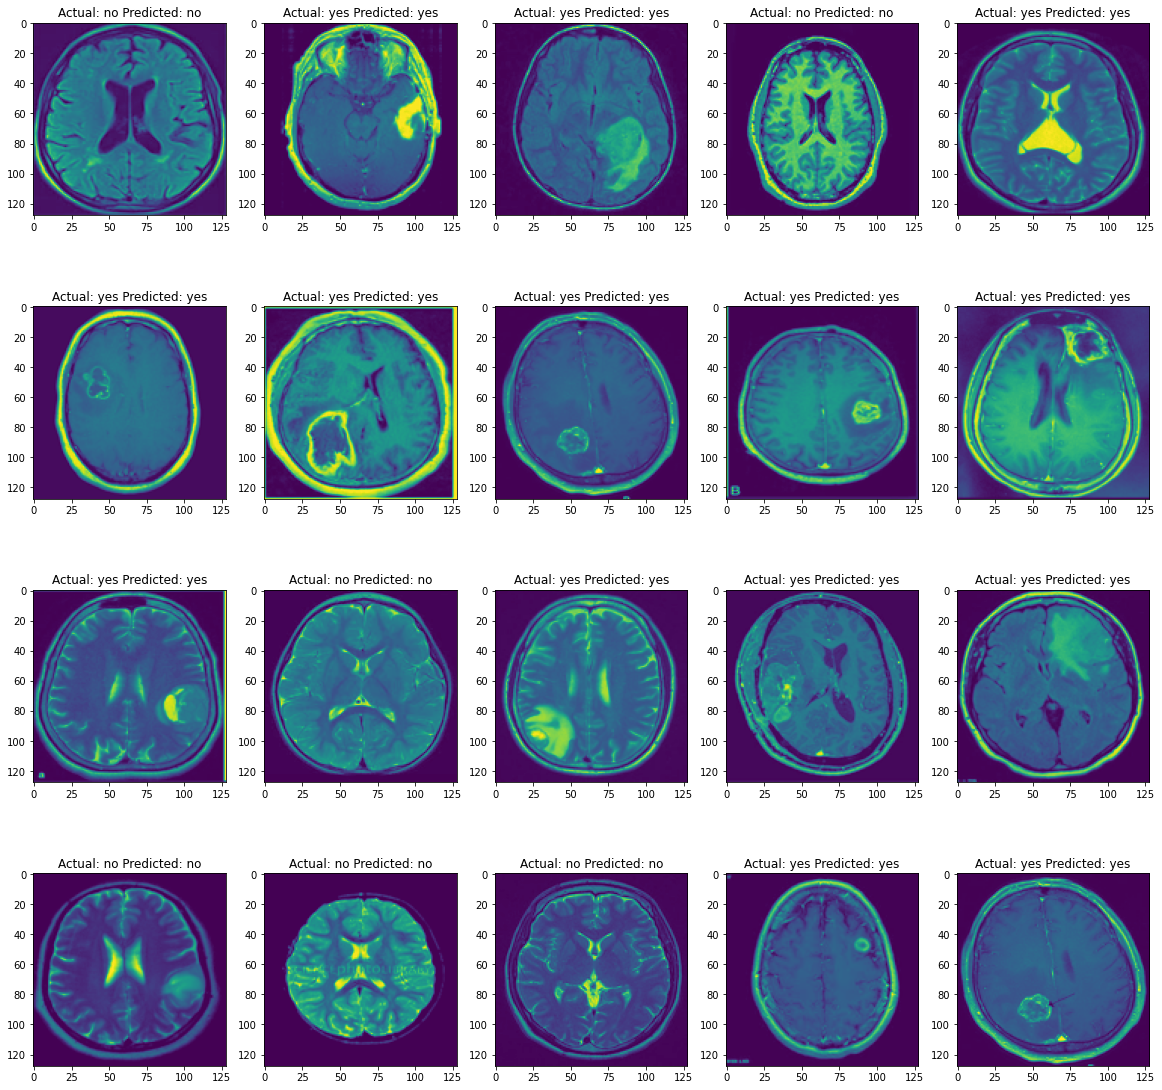

In [11]:
mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
for i in range(20):
    data,target = dataset[i]
    pred = model.forward(data.float())
    pred = torch.argmax(pred,dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(data[0][0].cpu())
    plt.title(f'Actual: {mapping[target.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
plt.show()